# Face Recognition using Facenet and SVM with PCA Visualization

The provided code implements a face recognition system using the [facenet-pytorch](https://www.kaggle.com/datasets/timesler/facenet-pytorch-vggface2) library and training using SVM Model. Here's a summary of the code:

1. Installation: The code installs the facenet-pytorch library from a local file using pip.
2. Model Checkpoints: The code copies the model checkpoints to the torch cache directory for automatic loading during runtime.
3. Importing Required Libraries: Necessary libraries and modules are imported for various functionalities, including image processing, machine learning, face detection, and feature extraction.
4. Helper Functions: Two helper functions are defined. The whitens function normalizes an input image tensor, and the extract_features function detects faces in an image and extracts their feature embeddings.
5. Device Configuration: The code sets the device to either GPU or CPU based on availability.
6. Model Initialization: The MTCNN and Inception ResNet V1 models are initialized with pre-trained weights. The models are moved to the selected device.
7. Dataset Preparation: The code defines the path to the dataset folder and creates ImageFolder datasets for the training and validation sets.
8. Embedding Extraction: The dataset_to_embeddings function is called to extract face embeddings from the training and validation sets.
9. Model Training: The train function is called to train the face recognition model using the extracted embeddings.
10. Model Saving: The trained model is serialized and saved as a pickle file.
11. Model Evaluation: The code generates a classification report and calculates the accuracy of the trained model using the embeddings from the training set.
12. Visualization: The code uses PCA to reduce the dimensionality of the embeddings and plots a 2D scatter plot of the embeddings with different colors representing different labels.
13. Image Testing: Random images from the validation set are selected and their predicted labels are compared with the true labels. The images, along with the predicted and actual labels, are displayed.
14. Single Image Testing: A single image is tested for face recognition, and the predicted label is displayed along with the image.

## Importing Required Libraries

The necessary libraries and modules are imported, including:

In [1]:
import os
import argparse
import joblib
import numpy as np
from PIL import Image
from torchvision import transforms, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
import joblib
import random
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import torch
from sklearn.decomposition import PCA
from sklearn import svm

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility Functions

The following utility functions are defined:

* **whitens(img):** Performs image whitening by subtracting the mean and dividing by the standard deviation of the image.
* **extract_features(mtcnn, facenet, img):** Extracts facial features from an image using the MTCNN face detection and the InceptionResnetV1 model. Returns the bounding boxes and embeddings of detected faces.
* **dataset_to_embeddings(dataset, mtcnn, facenet):** Converts a dataset of images into a list of embeddings and labels using the MTCNN and InceptionResnetV1 models.
* **train(embeddings, labels):** Train the embeddings and labels using SVM Model with True probability

In [2]:
def whitens(img):
        mean = img.mean()
        std = img.std()
        std_adj = std.clamp(min=1.0 / (float(img.numel()) ** 0.5))
        y = (img - mean) / std_adj
        return y
    
def extract_features(mtcnn, facenet, img):
        img = img.to(device)
        img = transforms.ToPILImage()(img.squeeze_(0))
        bbs, _ = mtcnn.detect(img)
        if bbs is None:
            # if no face is detected
            return None, None

        faces = torch.stack([extract_face(img, bb) for bb in bbs])
        embeddings = facenet(whitens(faces)).detach().numpy()

        return bbs, embeddings
    
def dataset_to_embeddings(dataset, mtcnn, facenet):
    transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])

    embeddings = []
    labels = []
    for img_path, label in dataset.samples:
        print(img_path)
        
        _, embedding = extract_features(mtcnn, facenet, transform(Image.open(img_path).convert('RGB')).unsqueeze_(0))
        if embedding is None:
            print("Could not find face on {}".format(img_path))
            continue
        if embedding.shape[0] > 1:
            print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
            embedding = embedding[0, :]
        embeddings.append(embedding.flatten())
        labels.append(label)

    return np.stack(embeddings), labels

def train(embeddings, labels):
    clf = svm.SVC(probability=True)
    clf.fit(embeddings, labels)
    return clf

## Model Initialization
The code initializes the MTCNN and InceptionResnetV1 models for face detection and feature extraction, respectively:

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device='cpu'

mtcnn = MTCNN(keep_all=True, thresholds=[0.6, 0.7, 0.9], device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval()

facenet = facenet.to(device)

## Dataset Preparation
The code defines the path to the dataset folder and creates ImageFolder datasets for training and validation:

In [4]:

data_path = "C:\\Users\\USER\\Desktop\\Computer Vision Project\\input\\facedata\\data"
train_path = "C:\\Users\\USER\\Desktop\\Computer Vision Project\\input\\facedata\\train"  
val_path = "C:\\Users\\USER\\Desktop\\Computer Vision Project\\input\\facedata\\val"     

dataset_train = datasets.ImageFolder(root=train_path)
dataset_val = datasets.ImageFolder(root=val_path)

## Generating Embeddings
The code generates embeddings and labels for the training and validation datasets using the dataset_to_embeddings function:

In [5]:
X_train, y_train = dataset_to_embeddings(dataset_train, mtcnn, facenet)
X_test, y_test = dataset_to_embeddings(dataset_val, mtcnn, facenet)
    
X_train_class_idx = dataset_train.class_to_idx
X_test_class_idx = dataset_val.class_to_idx

embeddings, labels, class_to_idx = X_train, y_train, X_train_class_idx

C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpcsvkmeuaeccjpg.jpg


C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg
C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg
C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg
C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg
C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg
C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg
C:\Users\USER\Desktop\Computer Vision Project\input\facedata\train\ben_afflek\httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAff

## Training
The code trains a classification model using the training embeddings and labels:

In [6]:
clf = train(embeddings, labels)
    
# Save the trained model
joblib.dump(clf, 'face_recognition_model.pkl')

['face_recognition_model.pkl']

## Model Evaluation
The code evaluates the trained model by printing a classification report and calculating the accuracy on the validation set:

In [7]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(idx_to_class)

target_names = list(map(lambda i: i[1], sorted(idx_to_class.items(), key=lambda i: i[0])))
print(metrics.classification_report(labels, clf.predict(embeddings), target_names=target_names))

# Predict labels for validation set and calculate accuracy
y_val_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_val_pred)
print('Validation Accuracy: {:.2f}%'.format(accuracy*100))

{0: 'ben_afflek', 1: 'elton_john', 2: 'jerry_seinfeld', 3: 'madonna', 4: 'mindy_kaling'}
                precision    recall  f1-score   support

    ben_afflek       1.00      1.00      1.00        14
    elton_john       1.00      1.00      1.00        16
jerry_seinfeld       1.00      1.00      1.00        21
       madonna       1.00      1.00      1.00        18
  mindy_kaling       1.00      1.00      1.00        22

      accuracy                           1.00        91
     macro avg       1.00      1.00      1.00        91
  weighted avg       1.00      1.00      1.00        91

Validation Accuracy: 100.00%


## Visualization
The code visualizes the embeddings in a 2D space using PCA and plots a scatter plot with colored points representing different classes:



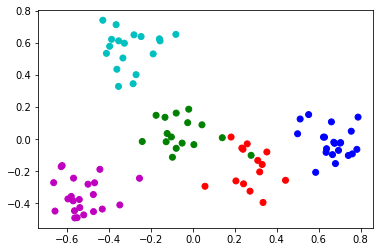

In [8]:
# Use PCA to reduce the dimensionality of the embeddings
pca = PCA(n_components=5)
embeddings_2d = pca.fit_transform(X_train)  

# Map numeric labels to actual names
mapped_labels = [idx_to_class[label] for label in y_train]  

# Define a function to assign colors to labels
def assign_colors(label):
    colors = {'ben_afflek': 'r', 'elton_john': 'g', 'jerry_seinfeld': 'b', 'madonna': 'c', 'mindy_kaling': 'm'}
    return colors[label]

# Create color array for all points
colors = list(map(assign_colors, mapped_labels))

# Plot the 2D embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
plt.show()

## Face Recognition

The code performs face recognition on randomly selected images from the validation set. It predicts the labels for the images and displays the predicted and actual labels along with the image:

[[0.01403219 0.93582062 0.01496903 0.01554511 0.01963304]]


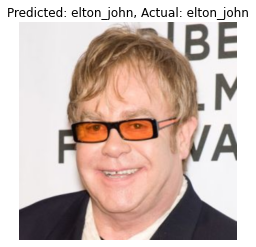

[[0.84124051 0.05554841 0.03490795 0.0299356  0.03836753]]


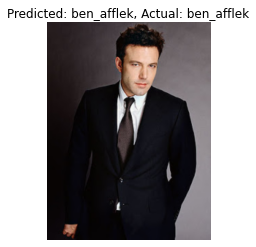

[[0.04157066 0.0460788  0.84781231 0.03638401 0.02815422]]


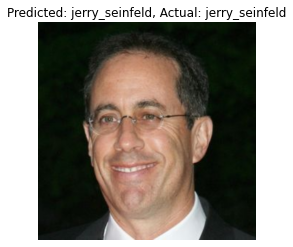

[[0.04732586 0.03487568 0.02191424 0.03369146 0.86219277]]


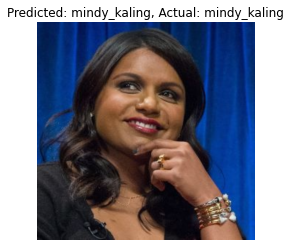

[[0.02238483 0.9263294  0.01579406 0.01700587 0.01848584]]


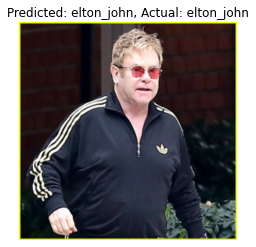

In [9]:

transform_img = transforms.Compose([transforms.Resize(1024)])
transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])



dataset_val = datasets.ImageFolder(root="C:\\Users\\USER\\Desktop\\Computer Vision Project\\input\\facedata\\val")
val_samples = dataset_val.samples


random_samples = random.choices(val_samples, k=5)

for img_path, true_label in random_samples:
    
    img_ = transform_img(Image.open(img_path).convert('RGB'))
    img = transform(Image.open(img_path).convert('RGB'))

    # Extract features
    _, embedding = extract_features(mtcnn, facenet, img)
    if embedding is None:
        print("Could not find face on {}".format(img_path))
        continue
    if embedding.shape[0] > 1:
        print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
        embedding = embedding[0, :]

    
    predicted_label = clf.predict(embedding.reshape(1, -1))
    print(clf.predict_proba(embedding))
    
    predicted_class = idx_to_class[predicted_label[0]]
    true_class = idx_to_class[true_label]
    
    plt.imshow(img_)
    plt.title(f'Predicted: {predicted_class}, Actual: {true_class}')
    plt.axis('off')
    plt.show()


## Intruder Recognition

The code performs face recognition on a single image specified by img_path and displays the predicted label along with the image:

[[0.1280412  0.27997874 0.06578291 0.3651624  0.16103475]]


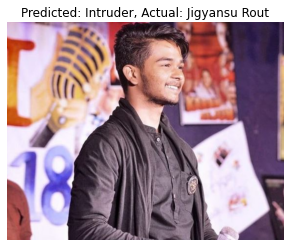

In [10]:
img_path = 'C:\\Users\\USER\\Desktop\\Computer Vision Project\\input\\jigyansu.JPG'

img_ = transform_img(Image.open(img_path).convert('RGB'))
img = transform(Image.open(img_path).convert('RGB'))
_, embedding = extract_features(mtcnn, facenet, img)

predicted_label = clf.predict(embedding.reshape(1, -1))
# Convert label indexes back to original classes
predicted_class = idx_to_class[predicted_label[0]]
true_class = idx_to_class[true_label]
print((clf.predict_proba(embedding)))
thres = 0.6
if np.max(clf.predict_proba(embedding)) < thres:
    predicted_class = 'Intruder'


plt.imshow(img_)
plt.title(f'Predicted: {predicted_class}, Actual: {"Jigyansu Rout"}')
plt.axis('off')
plt.show()